In [284]:
import pandas as pd
import json
import numpy as np
from globals import BASE_DIR
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score


top_k_resample = 50
top_k_eval = 10

general_models = ["BPR", "SimpleX"]
context_models = ["LORE", "USG"]

available_datasets = ["brightkite", "foursquaretky", "gowalla", "snoward", "yelp"]

dataset = "foursquaretky"

valid_popularity = "business_popularity:float"
#valid_popularity = "item_pop"

#recommendation_dirpart = "recommendations_with_cold_item_preprocessing"
recommendation_dirpart = "recommendations"

In [285]:
# Define the datasets you want to process
def dataset_metadata(dataset, recommendation_dirpart=recommendation_dirpart):
    data = []

    recs = os.listdir(f"{BASE_DIR}{dataset}_dataset/{recommendation_dirpart}")
    if '.DS_Store' in recs:
        recs.remove('.DS_Store')

    for dir in recs:
        json_file = f"{BASE_DIR}{dataset}_dataset/{recommendation_dirpart}/{dir}/general_evaluation.json"
        
        with open(json_file, 'r') as f:
            eval_data = json.load(f)
        
        # Extract the test_result data and flatten it
        test_results = eval_data.get("test_result", {})
        test_results["directory"] = dir

        test_results["dataset"] = test_results["directory"].split("-")[0]
        test_results["model"] = test_results["directory"].split("-")
        if test_results["directory"].split("-")[1] == "debias":
            test_results["model_type"] = "debias"
            test_results["date"] = "-".join(test_results["directory"].split("-")[3:])
        
        elif test_results["directory"].split("-")[1] == "contextpoi":
            test_results["model_type"] = "contextpoi"
            test_results["date"] = "-".join(test_results["directory"].split("-")[3:])
        else:
            test_results["model_type"] = "general"
            test_results["date"] = "-".join(test_results["directory"].split("-")[2:])

        if test_results["model_type"] == "debias":
            test_results["model"] = test_results["model"][2]
        
        elif test_results["model_type"] == "contextpoi":
            test_results["model"] = test_results["model"][2]
            
        else:
            test_results["model"] = test_results["model"][1]

        if test_results["model"] == "MF":
            test_results["model_type"] = "general (via RecBole debias)"

        test_results["dataset"] = test_results["dataset"].split("_")[0]
        if test_results["model_type"] != "debias":
            data.append(test_results)

    return data


In [286]:
def base_vs_calibrate_creator(dataset, recommender_dir, top_k_resample=100, top_k_eval=10, valid_popularity=valid_popularity, calibrate_on="mean"):
    checkin_df = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.inter", sep="\t")
    value_counts = checkin_df["item_id:token"].value_counts().reset_index()
    value_counts.columns = ["item_id:token", "count"]
    # max_count = value_counts["count"].max() 
    value_counts["item_pop"] = value_counts["count"] / len(value_counts) # the alternative is dividing it by the max_count
    checkin_df = checkin_df.merge(value_counts[["item_id:token", "item_pop"]], on = "item_id:token", how="left")
    checkin_df.sort_values(by=valid_popularity, ascending=False, inplace=True)
    item_popularity = checkin_df.drop_duplicates(subset="item_id:token", keep="first")[["item_id:token", valid_popularity]]

    h_group = item_popularity.head(int(len(item_popularity)*0.2))
    h_group["item_pop_group"] = "h"
    t_group = item_popularity.tail(int(len(item_popularity)*0.2))
    t_group["item_pop_group"] = "t"
    m_group = item_popularity[~item_popularity["item_id:token"].isin(h_group["item_id:token"]) & ~item_popularity["item_id:token"].isin(t_group["item_id:token"])]
    m_group["item_pop_group"] = "m"

    item_popularity = pd.concat([h_group,m_group,t_group])
    item_popularity.sort_values(by=valid_popularity, inplace=True, ascending=False)

    checkin_df = checkin_df.merge(item_popularity[["item_id:token", "item_pop_group"]], on="item_id:token", how="left")

    # Calculate the UPTS (user popularity tolerance score)
    if calibrate_on == "mean":
        upts = checkin_df.groupby("user_id:token")[valid_popularity].mean().reset_index()
    else:
        upts = checkin_df.groupby("user_id:token")[valid_popularity].median().reset_index()

    upts.columns = ["user_id:token", "upts"]
    upts.sort_values("upts", ascending=False, inplace=True)

    with open(recommender_dir) as f:
        data = json.load(f)

    base_recommendations = {}
    for user, items in data.items():
        for item in items[:top_k_resample]:
            top_k_base = item["item_id"]
            base_recommendations[user] = top_k_base
            if len(top_k_base) < top_k_resample:
                print(f"{user} has less than {top_k_resample} recommendations --> ({len(top_k_base)})")


    base_df = pd.DataFrame([
        {"user_id:token": user, "item_id:token": item} for user, items in base_recommendations.items() for item in items
    ])

    merged_df = base_df.merge(upts, on="user_id:token").merge(item_popularity, on="item_id:token")
    merged_df["upd"] = (merged_df[valid_popularity] - merged_df["upts"]).abs()


    sorted_top_k_df = (
        merged_df.sort_values(by=["user_id:token", "upd"], ascending=True)
        .groupby("user_id:token")
        .head(top_k_eval) 
        .reset_index(drop=True)
    )

    calibrated_top_k_recommendations = (
        sorted_top_k_df.groupby("user_id:token")["item_id:token"]
        .apply(list)
        .to_dict()
    )

    base_top_k_recommendations = {}
    for user, items in base_recommendations.items():
        base_top_k_recommendations[user] = items[:top_k_eval]

    calibrated_top_k_recommendations.keys() == base_top_k_recommendations.keys()

    base_df = pd.DataFrame([
        {"user_id:token": user, "item_id:token": item} for user, items in base_top_k_recommendations.items() for item in items
    ])

    calibrated_df = pd.DataFrame([
        {"user_id:token": user, "item_id:token": item} for user, items in calibrated_top_k_recommendations.items() for item in items
    ])

    base_df.merge(item_popularity, on="item_id:token").value_counts("item_pop_group", normalize=True)
    return base_df, calibrated_df, item_popularity, base_top_k_recommendations, calibrated_top_k_recommendations, upts

In [287]:
def open_ground_truth_user_group(dataset):
    # Stays the same across all models 
    test_data_dir = f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.test.inter"
    test_data = pd.read_csv(test_data_dir, sep="\t")
    user_group_dir = f"{BASE_DIR}{dataset}_dataset/{dataset}_user_id_popularity.json"
    with open(user_group_dir) as f:
        user_groups = json.load(f)

    return test_data, user_groups

In [288]:
def plot_popularity_distribution(ax, data, item_popularity, user_groups, label):
    # Merge the data
    data = data.merge(item_popularity, on="item_id:token", how="left")

    # Calculate normalized value counts for each user group
    g1 = data.loc[data["user_id:token"].isin(user_groups["high"])].value_counts("item_pop_group", normalize=True).rename("g1")
    g2 = data.loc[data["user_id:token"].isin(user_groups["medium"])].value_counts("item_pop_group", normalize=True).rename("g2")
    g3 = data.loc[data["user_id:token"].isin(user_groups["low"])].value_counts("item_pop_group", normalize=True).rename("g3")

    # Create a DataFrame from the Series
    distr_df = pd.DataFrame([g1, g2, g3]).fillna(0)  # Fill NaNs with 0 for missing groups

    # Specify the color order
    colors = ['blue', 'green', 'red']  # h, m, t colors in order

    # Plotting
    distr_df.plot(kind='bar', stacked=True, ax=ax, color=colors, legend=False)

    # Customize the plot
    ax.set_title(f"{label}")
    ax.set_xlabel("User Groups")
    ax.set_ylabel("Item Popularity Group Distribution")


In [289]:
# def ndcg(test_data, df):
#     # Assign relevance scores to the ground truth items in test_data
#     test_data['relevance'] = 1
#     ndcg_scores = {}
#     for user_id in df['user_id:token'].unique():
#         recommended_items = df[df['user_id:token'] == user_id]['item_id:token'].tolist()

#         true_items = test_data[test_data['user_id:token'] == user_id]
#         true_relevance = [1 if item in true_items['item_id:token'].values else 0 for item in recommended_items]
#         ndcg = ndcg_score([true_relevance], [list(range(len(recommended_items), 0, -1))]) 
#         ndcg_scores[user_id] = ndcg
#     return ndcg_scores

def ndcg(test_data, df):
    test_data['relevance'] = 1
    ndcg_scores = {}

    for user_id in df['user_id:token'].unique():
        recommended_items = df[df['user_id:token'] == user_id]['item_id:token'].tolist()
        recommended_items = recommended_items[:top_k_eval]
        true_items = test_data[test_data['user_id:token'] == user_id]
    
        # Calculate the true relevance for each recommended item
        true_relevance = [1 if item in true_items['item_id:token'].values else 0 for item in recommended_items]
        
        dcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(true_relevance))
        
        # Calculate ideal DCG (iDCG)
        sorted_relevance = sorted(true_relevance, reverse=True)
        idcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(sorted_relevance))
        
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores[user_id] = ndcg

    return ndcg_scores

def calculate_arp_poplift(df, item_popularity, user_profile_popularity, valid_popularity=valid_popularity):
    df = df.merge(item_popularity, on="item_id:token", how="left")
    df = df.merge(user_profile_popularity, on="user_id:token", how="left")


    arp_scores = df.groupby('user_id:token')[valid_popularity].mean().to_dict()
    upts_scores = df.groupby('user_id:token')['upts'].mean().to_dict()

    # Calculate poplift as the percentage deviation (ARP - UPP) / UPP for each user
    poplift_scores = {user_id: (arp_scores[user_id] - upts_scores[user_id]) / upts_scores[user_id] * 100 
                      for user_id in arp_scores if upts_scores[user_id] != 0}


    return arp_scores, poplift_scores



def calculate_deltas(test_data, base_df, calibrated_df, item_popularity, user_profile_popularity,model_name, valid_popularity=valid_popularity):
    base_ndcg_scores = ndcg(test_data, base_df)
    calibrated_ndcg_scores = ndcg(test_data, calibrated_df)    
    ndcg_delta_percentage = {user_id: ((calibrated_ndcg_scores[user_id] - base_ndcg_scores[user_id]) / base_ndcg_scores[user_id]) * 100 
                        for user_id in base_ndcg_scores if base_ndcg_scores[user_id] != 0}
    
    avg_ndcg_delta_percentage = abs(sum(ndcg_delta_percentage.values()) / len(ndcg_delta_percentage))

    base_arp_scores, base_poplift_scores = calculate_arp_poplift(base_df, item_popularity, user_profile_popularity, valid_popularity)
    calibrated_arp_scores, calibrated_poplift_scores = calculate_arp_poplift(calibrated_df, item_popularity, user_profile_popularity, valid_popularity)

    arp_delta_percentage = {user_id: ((calibrated_arp_scores[user_id] - base_arp_scores[user_id]) / base_arp_scores[user_id]) * 100 
                        for user_id in base_arp_scores if base_arp_scores[user_id] != 0}
    
    avg_arp_delta_percentage = abs(sum(arp_delta_percentage.values()) / len(arp_delta_percentage))

    poplift_delta_percentage = {user_id: ((calibrated_poplift_scores[user_id] - base_poplift_scores[user_id]) / base_poplift_scores[user_id]) * 100 
                        for user_id in base_poplift_scores if base_poplift_scores[user_id] != 0}
    
    avg_poplift_delta_percentage = abs(sum(poplift_delta_percentage.values()) / len(poplift_delta_percentage))

    print(f"{model_name} Base vs. Calibrated Results")
    print(f"Abs. nDCG % change: {avg_ndcg_delta_percentage:,.2f}%; base: {sum(base_ndcg_scores.values()) / len(base_ndcg_scores):,.5f}; calibrated: {sum(calibrated_ndcg_scores.values()) / len(calibrated_ndcg_scores):,.5f}")
    print(f"Abs. ARP % change : {avg_arp_delta_percentage:,.2f}%; base: {sum(base_arp_scores.values()) / len(base_arp_scores):,.5f}; calibrated: {sum(calibrated_arp_scores.values()) / len(calibrated_arp_scores):,.5f}")
    print(f"Abs. Poplift % change : {avg_poplift_delta_percentage:,.2f}%; base: {sum(base_poplift_scores.values()) / len(base_poplift_scores):,.5f}; calibrated: {sum(calibrated_poplift_scores.values()) / len(calibrated_poplift_scores):,.5f}")
    print("*"*50)





# def delta_ndcg_scores_by_group(test_data, base_df, calibrated_df, user_groups):
#     group_deltas = {}
#     for group_name, user_ids in user_groups.items():
#         base_group = base_df[base_df['user_id:token'].isin(user_ids)]
#         calibrated_group = calibrated_df[calibrated_df['user_id:token'].isin(user_ids)]
#         base_ndcg_scores = ndcg(test_data, base_group)
#         calibrated_ndcg_scores = ndcg(test_data, calibrated_group)
        
#         delta_ndcg_scores = {user_id: calibrated_ndcg_scores[user_id] - base_ndcg_scores[user_id] 
#                              for user_id in base_ndcg_scores}
        
#         avg_delta = sum(delta_ndcg_scores.values()) / len(delta_ndcg_scores)
        
#         delta_percentage = {user_id: ((calibrated_ndcg_scores[user_id] - base_ndcg_scores[user_id]) / base_ndcg_scores[user_id]) * 100 
#                             for user_id in base_ndcg_scores if base_ndcg_scores[user_id] != 0}
                            
        
#         avg_delta_percentage = sum(delta_percentage.values()) / len(delta_percentage)
        
#         group_deltas[group_name] = {
#             "avg_delta_ndcg": avg_delta,
#             "avg_delta_percentage": avg_delta_percentage,
#             "base_avg_ndcg": sum(base_ndcg_scores.values()) / len(base_ndcg_scores),
#             "calibrated_avg_ndcg": sum(calibrated_ndcg_scores.values()) / len(calibrated_ndcg_scores)
#         }
        
#         print(f"Group: {group_name} - Average Delta nDCG Percentage: {avg_delta_percentage:.2f}%; "
#               f"base nDCG: {group_deltas[group_name]['base_avg_ndcg']:.5f}; "
#               f"calibrated nDCG: {group_deltas[group_name]['calibrated_avg_ndcg']:.5f}")
#     print("*"*50)
#     return group_deltas






In [290]:
def recommender_dir_combiner(dataset, modelpart):
    return f"{BASE_DIR}{dataset}_dataset/{recommendation_dirpart}/{modelpart}/top_k_recommendations.json"


In [291]:
data = dataset_metadata(dataset)
for result in data:
    if result["model"] == general_models[0]:
        general1_dir = recommender_dir_combiner(dataset, result["directory"])
    elif result["model"] == general_models[1]:
        general2_dir = recommender_dir_combiner(dataset, result["directory"])
    elif result["model"] == context_models[0]:
        context1_dir = recommender_dir_combiner(dataset, result["directory"])
    elif result["model"] == context_models[1]:
        context2_dir = recommender_dir_combiner(dataset, result["directory"])

test_data, user_groups = open_ground_truth_user_group(dataset)
base_df_general1, calibrated_df_general1, item_popularity, base_general_rec1, cal_general_rec1, upts = base_vs_calibrate_creator(dataset, general1_dir, top_k_resample, top_k_eval)
base_df_general2, calibrated_df_general2, item_popularity, base_general_rec2, cal_general_rec2, upts = base_vs_calibrate_creator(dataset, general2_dir, top_k_resample, top_k_eval)
base_df_context1, calibrated_df_context1, item_popularity, base_context_rec1, cal_context_rec1, upts = base_vs_calibrate_creator(dataset, context1_dir, top_k_resample, top_k_eval)
base_df_context2, calibrated_df_context2, item_popularity, base_context_rec2, cal_context_rec2, upts = base_vs_calibrate_creator(dataset, context2_dir, top_k_resample, top_k_eval)


/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_65782/169328651.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_group["item_pop_group"] = "h"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_65782/169328651.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_group["item_pop_group"] = "t"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_65782/169328651.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [292]:
item_popularity

,item_id:token,business_popularity:float,item_pop_group
18941,7_x,1.000000,h
4887,54_x,0.978469,h
57160,77_x,0.830941,h
22931,31_x,0.803030,h
9471,13_x,0.651515,h
...,...,...,...
5905,1712_x,0.007974,t
4761,1537_x,0.007974,t
26562,2725_x,0.007974,t
56966,2625_x,0.007974,t


In [293]:
def calibrate_full_unseen_data(dataset, upts, item_popularity):
    checkin_df = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.inter", sep="\t")
    train_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.train.inter", sep="\t")
    valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t")

    train_data = pd.concat([train_data, valid_data], ignore_index=True)
    checkin_df = checkin_df.merge(item_popularity[["item_id:token", "item_pop_group"]], on="item_id:token", how="left")
    checkin_df = checkin_df.merge(upts, on="user_id:token", how="left")
    checkin_df["upd"] = (checkin_df[valid_popularity] - checkin_df["upts"]).abs()

    users = checkin_df['user_id:token'].unique()
    items = checkin_df['item_id:token'].unique()

    # create a df with all possible user-item combinations
    user_item_pairs = pd.MultiIndex.from_product([users, items], names=['user_id:token', 'item_id:token']).to_frame(index=False)

    full_users_items_df = user_item_pairs.merge(
        checkin_df[['user_id:token', 'upts']].drop_duplicates(), on='user_id:token', how='left'
    ).merge(
        checkin_df[['item_id:token', valid_popularity]].drop_duplicates(), on='item_id:token', how='left'
    )
    full_users_items_df['upd'] = (full_users_items_df[valid_popularity] - full_users_items_df['upts']).abs()

    filtered_checkins = full_users_items_df.merge(train_data[['user_id:token', 'item_id:token']], 
                                on=['user_id:token', 'item_id:token'], 
                                how='left', indicator=True)

    # Keep only pairs that do not appear in train_data
    filtered_checkins = filtered_checkins[filtered_checkins['_merge'] == 'left_only'].drop(columns=['_merge'])
    filtered_checkins = filtered_checkins.sort_values(by=["user_id:token", "upd"], ascending=True)
    

    top_k_eval_df = filtered_checkins.groupby("user_id:token").head(top_k_eval).reset_index(drop=True)

    return top_k_eval_df




In [294]:
full_unseen_calibrate_df = calibrate_full_unseen_data(dataset, upts, item_popularity)

In [295]:
full_unseen_calibrate_df

,user_id:token,item_id:token,upts,business_popularity:float,upd
0,0_x,63_x,0.057416,0.057416,4.857226e-17
1,0_x,340_x,0.057416,0.057416,4.857226e-17
2,0_x,528_x,0.057416,0.057416,4.857226e-17
3,0_x,608_x,0.057416,0.057416,4.857226e-17
4,0_x,1144_x,0.057416,0.057416,4.857226e-17
...,...,...,...,...,...
14995,9_x,561_x,0.045455,0.045455,0.000000e+00
14996,9_x,890_x,0.045455,0.045455,0.000000e+00
14997,9_x,1227_x,0.045455,0.045455,0.000000e+00
14998,9_x,23_x,0.045455,0.046252,7.974482e-04


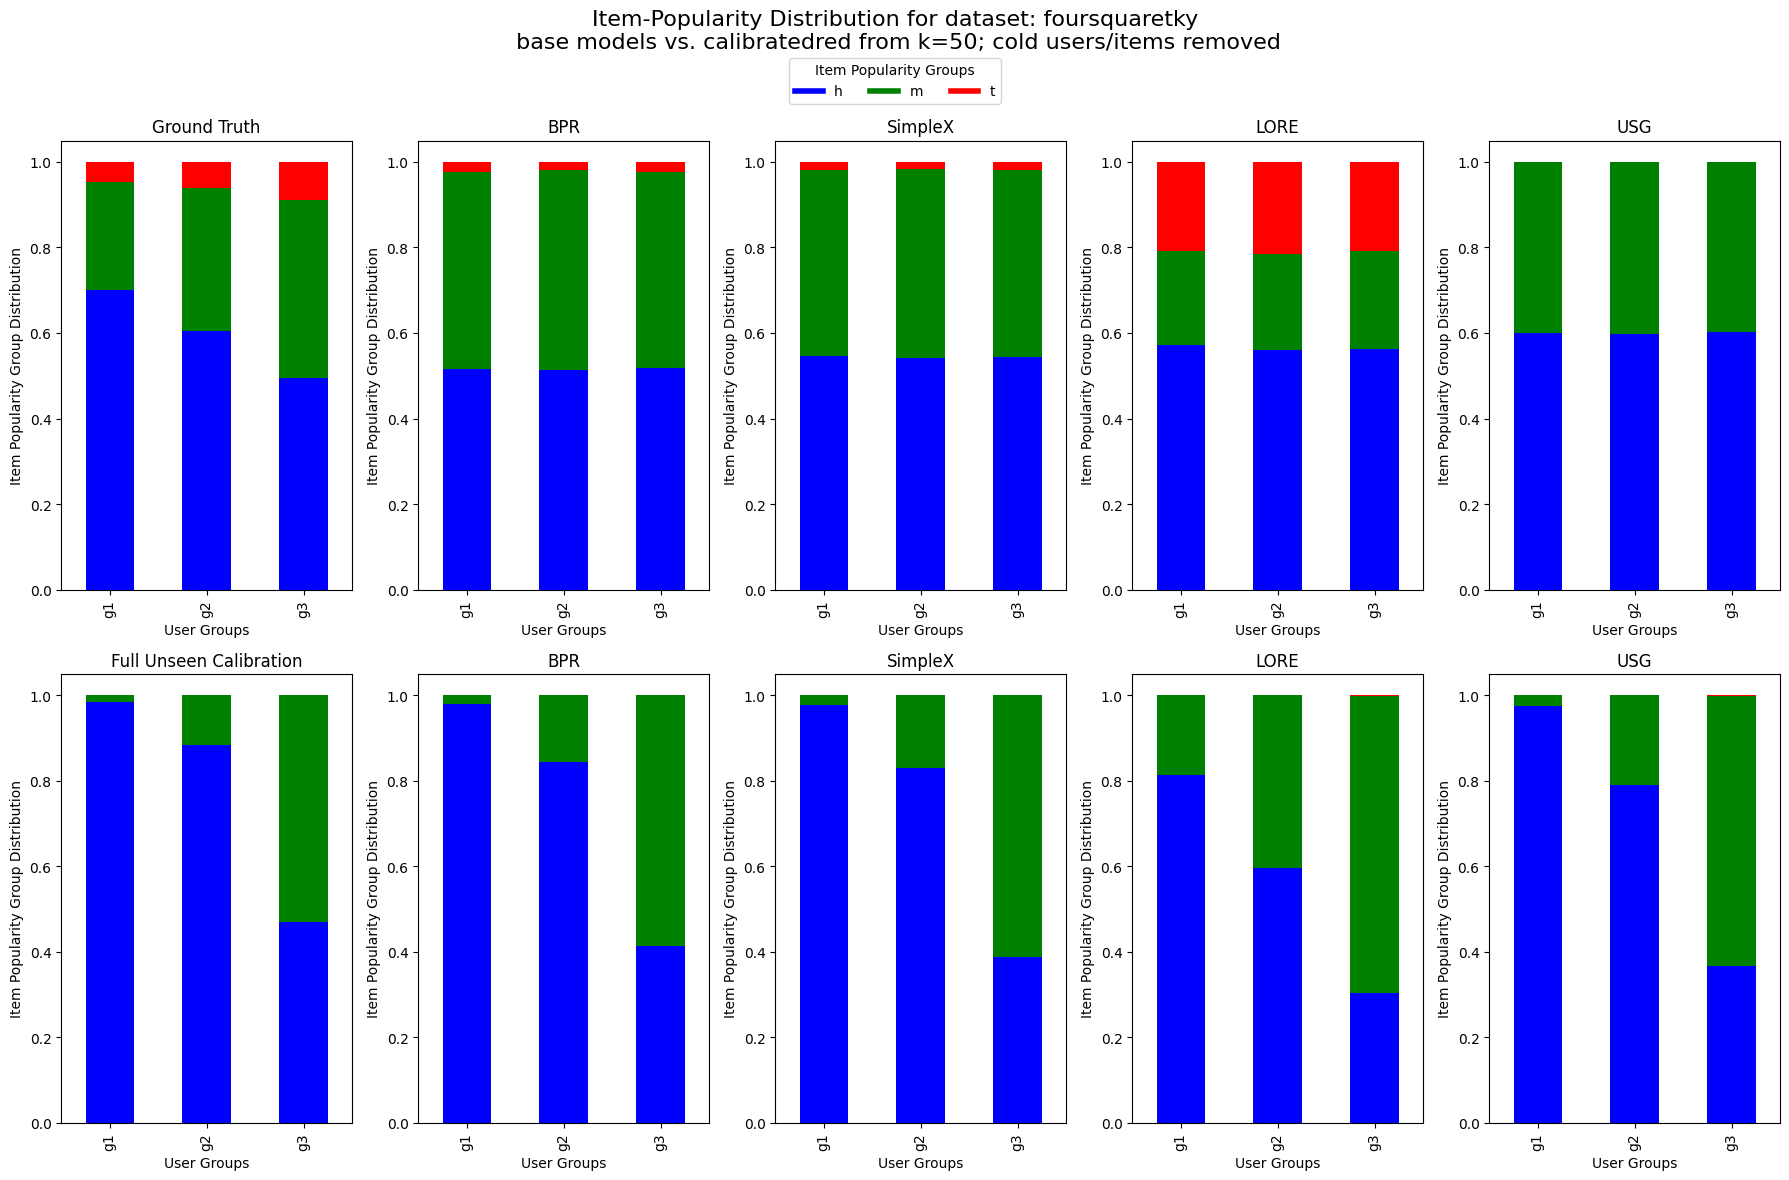

In [296]:

fig, axs = plt.subplots(2, 5, figsize=(18, 12))  # 2 rows, 5 columns

# Base Models
plot_popularity_distribution(axs[0, 0], test_data, item_popularity, user_groups, "Ground Truth")
plot_popularity_distribution(axs[0, 1], base_df_general1, item_popularity, user_groups, general_models[0])
plot_popularity_distribution(axs[0, 2], base_df_general2, item_popularity, user_groups, general_models[1])
plot_popularity_distribution(axs[0, 3], base_df_context1, item_popularity, user_groups, context_models[0])
plot_popularity_distribution(axs[0, 4], base_df_context2, item_popularity, user_groups, context_models[1])

# Calibrated Models
plot_popularity_distribution(axs[1, 0], full_unseen_calibrate_df, item_popularity, user_groups, "Full Unseen Calibration")
plot_popularity_distribution(axs[1, 1], calibrated_df_general1, item_popularity, user_groups, general_models[0])
plot_popularity_distribution(axs[1, 2], calibrated_df_general2, item_popularity, user_groups, general_models[1])
plot_popularity_distribution(axs[1, 3], calibrated_df_context1, item_popularity, user_groups, context_models[0])
plot_popularity_distribution(axs[1, 4], calibrated_df_context2, item_popularity, user_groups, context_models[1])

fig.suptitle(f"Item-Popularity Distribution for dataset: {dataset}\n base models vs. calibratedred from k={top_k_resample}; cold users/items removed", fontsize=16)

handles = [plt.Line2D([0], [0], color=color, lw=4) for color in ['blue', 'green', 'red']]
labels = ['h', 'm', 't']
fig.legend(handles, labels, title="Item Popularity Groups", loc='upper center', bbox_to_anchor=(0.5, 0.945), ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"{BASE_DIR}{dataset}_dataset/plots/item_popularity_distribution.png")
plt.show()

In [297]:
print(f"Dataset: {dataset}")
calculate_deltas(test_data, base_df_general1, calibrated_df_general1, item_popularity, upts, general_models[0])
calculate_deltas(test_data, base_df_general2, calibrated_df_general2, item_popularity, upts, general_models[1])
calculate_deltas(test_data, base_df_context1, calibrated_df_context1, item_popularity, upts, context_models[0])
calculate_deltas(test_data, base_df_context2, calibrated_df_context2, item_popularity, upts, context_models[1])


#calculate_deltas(test_data, base_df_general1, full_unseen_calibrate_df, item_popularity, upts, f"{general_models[0]} vs. Full Unseen Sort")


Dataset: foursquaretky
BPR Base vs. Calibrated Results
Abs. nDCG % change: 83.13%; base: 0.03161; calibrated: 0.02715
Abs. ARP % change : 0.45%; base: 0.06218; calibrated: 0.05224
Abs. Poplift % change : 100.62%; base: 49.53767; calibrated: -2.05361
**************************************************
SimpleX Base vs. Calibrated Results
Abs. nDCG % change: 85.84%; base: 0.03499; calibrated: 0.02489
Abs. ARP % change : 9.71%; base: 0.06937; calibrated: 0.05160
Abs. Poplift % change : 3,524,348,033,848.18%; base: 66.09255; calibrated: -2.92536
**************************************************
LORE Base vs. Calibrated Results
Abs. nDCG % change: 21.18%; base: 0.01743; calibrated: 0.03033
Abs. ARP % change : 70.91%; base: 0.02669; calibrated: 0.03965
Abs. Poplift % change : 3,343,255,051,711.41%; base: -36.00431; calibrated: -19.58392
**************************************************
USG Base vs. Calibrated Results
Abs. nDCG % change: 85.03%; base: 0.03261; calibrated: 0.02523
Abs. ARP % c

In [298]:
# group_deltas_general1 = delta_ndcg_scores_by_group(test_data, base_df_general1, calibrated_df_general1, user_groups)
# group_deltas_general2 = delta_ndcg_scores_by_group(test_data, base_df_general2, calibrated_df_general2, user_groups)
# group_deltas_context1 = delta_ndcg_scores_by_group(test_data, base_df_context1, calibrated_df_context1, user_groups)
# group_deltas_context2 = delta_ndcg_scores_by_group(test_data, base_df_context2, calibrated_df_context2, user_groups)